In [1]:
# 3 h 15m, 36 epochs

from classifier import *
from datasets import *
import os

torch.multiprocessing.set_sharing_strategy('file_system')

cwd = os.getcwd()
os.chdir('..')

In [22]:
import os

name = 'all_in_one_test'
version = 1

model = Net(classes)

logger = pl.loggers.TensorBoardLogger('lightning_logs', name=name, version=version)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=-1,
    logger=logger,
    log_every_n_steps=20,
    callbacks=[
        pl.callbacks.progress.TQDMProgressBar(refresh_rate=20),
        pl.callbacks.ModelCheckpoint(monitor="val_loss", save_last=True, save_top_k=3, filename='{epoch}-{val_loss:.3f}-{val_acc:.3f}')
    ],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
testloader = data.DataLoader(EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000), batch_size=64, num_workers=6)

In [4]:
# trainer.test(model, testloader, ckpt_path='lightning_logs/all_in_one/version_1/checkpoints/epoch=2-val_loss=0.285-val_acc=0.916.ckpt')

Restoring states from the checkpoint path at lightning_logs/all_in_one/version_1/checkpoints/epoch=2-val_loss=0.285-val_acc=0.916.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/all_in_one/version_1/checkpoints/epoch=2-val_loss=0.285-val_acc=0.916.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9241825938224792
        test_loss           0.25358548760414124
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.25358548760414124, 'test_acc': 0.9241825938224792}]

In [5]:
# trainer.test(model, testloader, ckpt_path='lightning_logs/all_in_one/version_1/checkpoints/epoch=20-val_loss=0.289-val_acc=0.921.ckpt')

Restoring states from the checkpoint path at lightning_logs/all_in_one/version_1/checkpoints/epoch=20-val_loss=0.289-val_acc=0.921.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/all_in_one/version_1/checkpoints/epoch=20-val_loss=0.289-val_acc=0.921.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.935114860534668
        test_loss           0.22376705706119537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.22376705706119537, 'test_acc': 0.935114860534668}]

In [24]:
trainer.test(model, testloader, ckpt_path='lightning_logs/all_in_one/version_1/checkpoints/epoch=25-val_loss=0.291-val_acc=0.931.ckpt')

Restoring states from the checkpoint path at lightning_logs/all_in_one/version_1/checkpoints/epoch=25-val_loss=0.291-val_acc=0.931.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at lightning_logs/all_in_one/version_1/checkpoints/epoch=25-val_loss=0.291-val_acc=0.931.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9389614462852478
        test_loss           0.21155700087547302
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.21155700087547302, 'test_acc': 0.9389614462852478}]

In [ ]:
# testloader = data.DataLoader(EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000), batch_size=1, num_workers=1)
# import time
# start = time.time()
# iters = 1
# for i in range(iters):
#     trainer.test(model, testloader, ckpt_path=f'lightning_logs/all_in_one/version_2/checkpoints/epoch=13-val_loss=0.723-val_acc=0.879.ckpt')
# print((time.time() - start)/iters)

In [18]:
from tqdm import tqdm

# testloader = data.DataLoader(EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000), batch_size=1, num_workers=1)
testloader = data.DataLoader(EvalSet(split='test', corner_sinks_ratio=None), batch_size=64, num_workers=1)

all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for x, y in tqdm(testloader):
        preds = model(x).argmax(1).numpy()
        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

100%|██████████| 19215/19215 [10:55<00:00, 29.30it/s]


In [19]:
cm = tm.ConfusionMatrix(len(classes))
matrix = cm(all_preds, all_gt).numpy()

In [20]:
tp = np.diag(matrix)
acc = tp/np.sum(matrix, axis=1)
precision = tp/np.sum(matrix, axis=0)

In [26]:
from tqdm import tqdm

# evalset = EvalSet(split='test', corner_sinks_ratio=None, n_toilet_samples=2000, n_sink_samples=2000)
evalset = EvalSet(split='test', corner_sinks_ratio=None)
testloader = data.DataLoader(evalset, batch_size=1, num_workers=1)

all_preds = []
all_gt = []
model.eval()
with torch.no_grad():
    for idx, (x, y) in tqdm(enumerate(testloader)):
        
        filename = evalset.all_files[idx]
        preds = model(x)

        if 'doors' in filename:
            preds = preds[:, :13].argmax(1).numpy()
        elif 'toilets' in filename:
            preds = preds[:, 13:-1].argmax(1).numpy() + 13
        else:
            preds = preds[:, 13:].argmax(1).numpy() + 13

        all_preds.append(list(preds))
        all_gt.append(y.numpy())

all_preds = torch.as_tensor(np.array([item for sublist in all_preds for item in sublist]))
all_gt = torch.as_tensor(np.array([item for sublist in all_gt for item in sublist]))

19215it [10:51, 29.51it/s]


In [27]:
cm = tm.ConfusionMatrix(len(classes))
matrix_cond = cm(all_preds, all_gt).numpy()

In [23]:
tp_cond = np.diag(matrix_cond)
acc_cond = tp_cond/np.sum(matrix_cond, axis=1)
precision_cond = tp_cond/np.sum(matrix_cond, axis=0)

In [20]:
from scipy import linalg

doors_cm = np.loadtxt('doors_notebooks/doors_cm.txt', dtype=int)
toilets_cm = np.loadtxt('report_toilets/toilets_cm.txt', dtype=int)
sinks_cm = np.loadtxt('report_sinks/sinks_cm.txt', dtype=int)

toilets_expanded = np.hstack((toilets_cm, np.zeros((toilets_cm.shape[0], 1), dtype=int)))
toilets_expanded = np.vstack((toilets_expanded, np.zeros((1, toilets_expanded.shape[1]), dtype=int)))
toilets_and_sinks = toilets_expanded + sinks_cm

total = linalg.block_diag(doors_cm, toilets_and_sinks)

tp_separate = np.diag(total)
acc_separate = tp_separate/np.sum(total, axis=1)
precision_separate = tp_separate/np.sum(total, axis=0)

Normal matrix


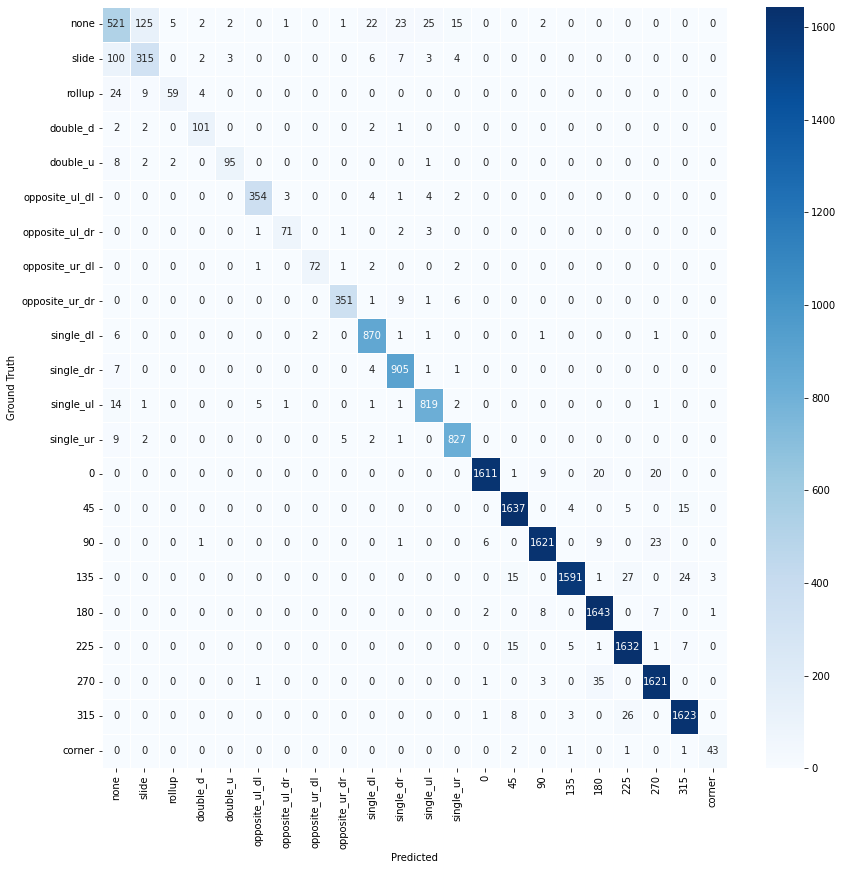

Conditional matrix


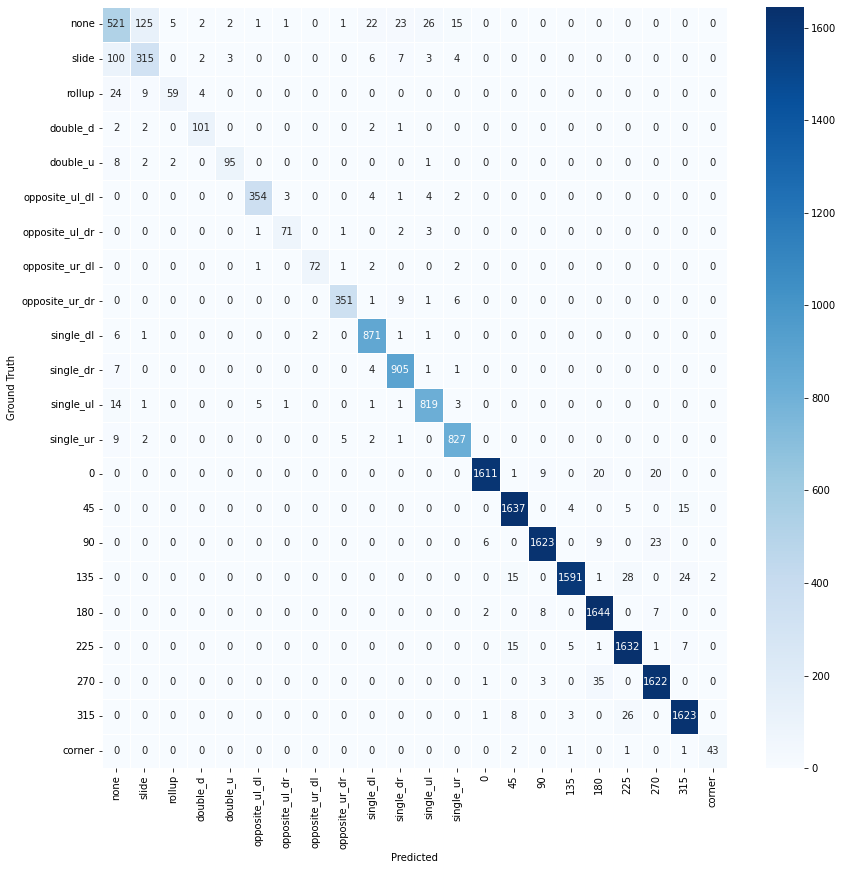

normal results
class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur,0,45,90,135,180,225,270,315,corner
accuracy,70.03,71.59,61.46,93.52,87.96,96.20,91.03,92.31,95.38,98.64,98.58,96.92,97.75,96.99,98.56,97.59,95.79,98.92,98.25,97.59,97.71,89.58
precision,75.40,69.08,89.39,91.82,95.00,97.79,93.42,97.30,97.77,95.19,95.06,95.45,96.27,99.38,97.56,98.60,99.19,96.14,96.51,96.83,97.19,91.49

conditional results
class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur,0,45,90,135,180,225,270,315,corner
accuracy,70.03,71.59,61.46,93.52,87.96,96.20,91.03,92.31,95.38,98.75,98.58,96.92,97.75,96.99,98.56,97.71,95.79,98.98,98.25,97.65,97.71,89.58
precision,75.40,68.93,89.39,92.66,95.00,97.79,93.42,97.30,97.77,95.19,95.16,95.34,96.16,99.38,97.56,98.78,99.19,96.14,96.45,96.95,97.19,95.56


In [27]:
import seaborn as sn

print('Normal matrix')
plt.figure(figsize=(14, 14))
ax = plt.axes()
ax = sn.heatmap(matrix, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('all_in_one/all_in_one_results.svg')
plt.show()

print('Conditional matrix')
plt.figure(figsize=(14, 14))
ax = plt.axes()
ax = sn.heatmap(matrix_cond, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('all_in_one/all_in_one_conditional_results.svg')
plt.show()
print('normal results')
print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision]))

print()
print('conditional results')
print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc_cond]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision_cond]))

Separate matrix


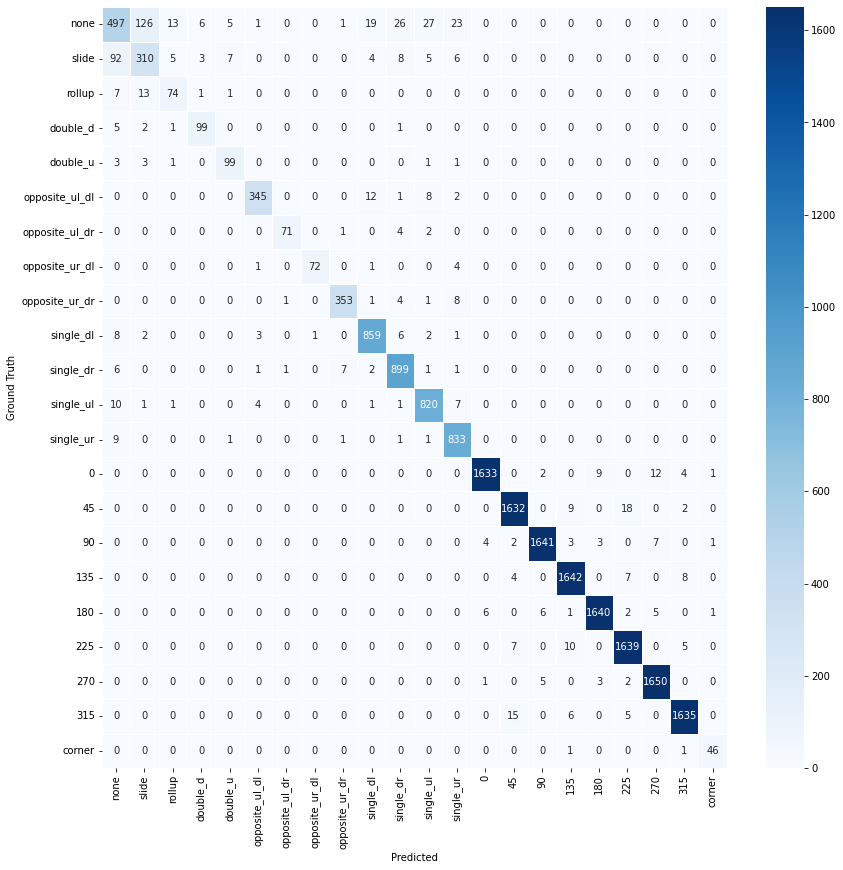

separate results
class,none,slide,rollup,double_d,double_u,opposite_ul_dl,opposite_ul_dr,opposite_ur_dl,opposite_ur_dr,single_dl,single_dr,single_ul,single_ur,0,45,90,135,180,225,270,315,corner
accuracy,66.80,70.45,77.08,91.67,91.67,93.75,91.03,92.31,95.92,97.39,97.93,97.04,98.46,98.31,98.25,98.80,98.86,98.74,98.68,99.34,98.43,95.83
precision,78.02,67.83,77.89,90.83,87.61,97.18,97.26,98.63,97.25,95.55,94.53,94.47,94.02,99.33,98.31,99.21,98.21,99.09,97.97,98.57,98.79,93.88


In [29]:
import seaborn as sn

print('Separate matrix')
plt.figure(figsize=(14, 14))
ax = plt.axes()
ax = sn.heatmap(total, annot=True, fmt='g', cmap='Blues', linewidth=.5, xticklabels=classes, yticklabels=classes, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.savefig('all_in_one/all_in_one_separate_results.svg')
plt.show()
print('separate results')
print('class,'+ ','.join([str(c) for c in classes]))
print('accuracy,'+ ','.join([f'{el*100:4.2f}' for el in acc_separate]))
print('precision,'+ ','.join([f'{el*100:4.2f}' for el in precision_separate]))

In [12]:
trainloader = data.DataLoader(TrainSet(), batch_size=1, sampler=get_train_sampler(num_samples=30000), num_workers=0)
valloader = data.DataLoader(EvalSet(n_toilet_samples=2000, n_sink_samples=2000), batch_size=1, num_workers=0)

In [33]:
d = {c: 0 for c in classes}

for x, y in trainloader:
    cls = classes[y]
    d[cls] += 1

<BarContainer object of 22 artists>

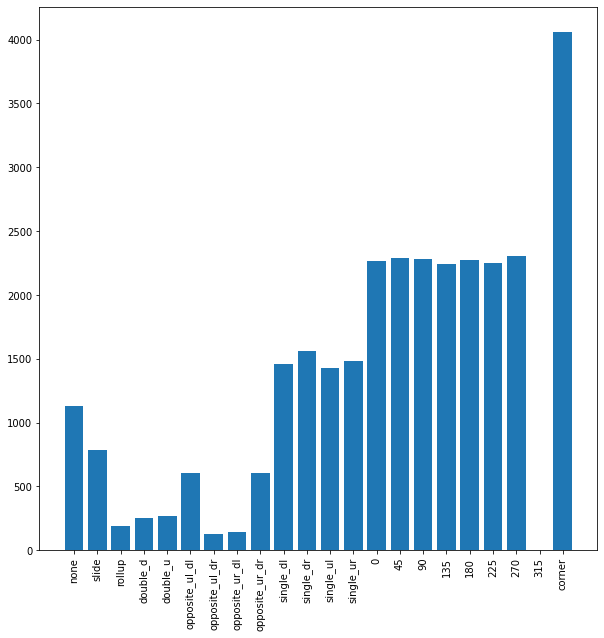

In [44]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation='vertical')
plt.bar(range(len(d)), list(d.values()), tick_label=list(d.keys()))

In [45]:
d_val = {c: 0 for c in classes}

for x, y in valloader:
    cls = classes[y]
    d_val[cls] += 1

<BarContainer object of 22 artists>

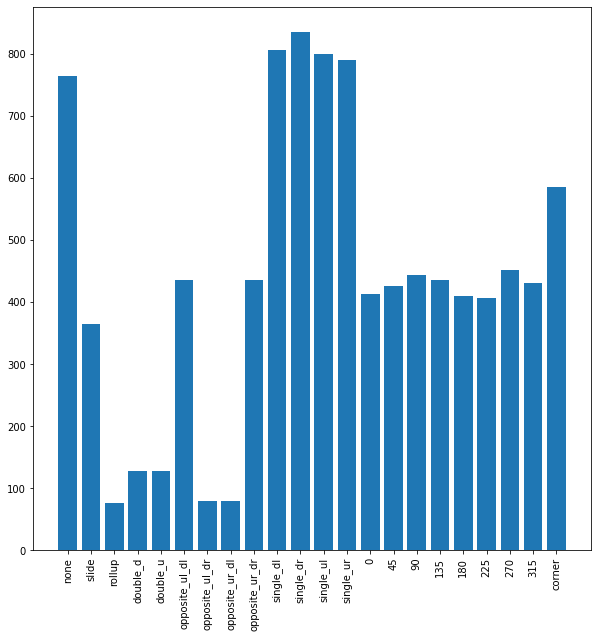

In [46]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation='vertical')
plt.bar(range(len(d_val)), list(d_val.values()), tick_label=list(d_val.keys()))